In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# !pip install tableone
from tableone import TableOne
# !pip install psycopg2-binary
import psycopg2

In [2]:
# create a database connection
sqluser = 'asem'
dbname = 'mimiciv'
hostname = 'localhost'
password='qwerasdf'
hosp_schema_name = 'mimiciv_hosp'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, password=password)

In [43]:
query = \
"""
SELECT
      pat.subject_id
    , adm.hadm_id
    , DENSE_RANK() OVER hadm_window AS hosp_stay_num
    , CASE
        WHEN FIRST_VALUE(adm.hadm_id) OVER hadm_window = adm.hadm_id THEN 1
        ELSE 0
      END AS pat_count
    , pat.anchor_age + (EXTRACT(YEAR FROM adm.admittime) - pat.anchor_year) AS age
    , pat.gender
    , adm.insurance
    , mimiciv_derived.DATETIME_DIFF(adm.dischtime, adm.admittime, 'HOUR') / 24 AS hosp_los
    , pat.dod
    , mimiciv_derived.DATETIME_DIFF(pat.dod, CAST(adm.dischtime AS DATE), 'DAY') AS days_to_death
    -- mortality flags
    , CASE WHEN mimiciv_derived.DATETIME_DIFF(pat.dod, CAST(adm.dischtime AS DATE), 'DAY') = 0 THEN 1 ELSE 0 END AS hospital_mortality
FROM mimiciv_hosp.patients pat
INNER JOIN mimiciv_hosp.admissions adm
    ON pat.subject_id = adm.subject_id
WINDOW hadm_window AS (PARTITION BY pat.subject_id ORDER BY adm.admittime)
"""

hosp = pd.read_sql_query(query,con)

In [85]:
# Admission IDs with Length of Stay at least 12 hours.
hadm_id_los_geq_12h = hosp[hosp.hosp_los > 0.5].hadm_id
hadm_id_los_geq_12h

0         22595853
1         22841357
2         29079034
3         25742920
5         23052089
            ...   
431226    29734428
431227    25744818
431228    26071774
431229    21033226
431230    23865745
Name: hadm_id, Length: 392689, dtype: int64

In [45]:
adm_df = pd.read_sql_query("""
SELECT subject_id, hadm_id, admittime, dischtime FROM mimiciv_hosp.admissions
""", con)
adm_df

,subject_id,hadm_id,admittime,dischtime
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00
...,...,...,...,...
431226,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00
431227,19999828,29734428,2147-07-18 16:23:00,2147-08-04 18:10:00
431228,19999840,21033226,2164-09-10 13:47:00,2164-09-17 13:42:00
431229,19999840,26071774,2164-07-25 00:27:00,2164-07-28 12:15:00


In [31]:

# add 1 year mortality
hosp['one_year_mortality'] = hosp['days_to_death'].notnull().astype(int)

# create a dataframe with the days to death for only the last ICU stay
last_dod = hosp.groupby('subject_id')[['hosp_stay_num']].max().reset_index()
last_dod = last_dod.merge(hosp[['subject_id', 'hosp_stay_num', 'days_to_death']], on=['subject_id', 'hosp_stay_num'], how='inner')
last_dod.rename(columns={'days_to_death': 'days_to_death_last_stay_id'}, inplace=True)

hosp = hosp.merge(last_dod, how='left', on=['subject_id', 'hosp_stay_num'])
del last_dod
hosp.sort_values(['subject_id', 'hosp_stay_num'], inplace=True)

# fix some data type issues
int_cols = hosp.dtypes.values=="Int64"
hosp.loc[:, int_cols] = hosp.loc[:, int_cols].astype(float)
hosp.loc[:, int_cols] = hosp.loc[:, int_cols].astype(int, errors="ignore")


In [33]:
query = \
"""
SELECT
      pat.subject_id
    , adm.hadm_id
    , icu.stay_id
    , ROW_NUMBER() OVER (PARTITION BY pat.subject_id ORDER BY icu.intime) AS icu_stay_num
    , DENSE_RANK() OVER (PARTITION BY pat.subject_id ORDER BY adm.admittime) AS hosp_stay_num
    , CASE
        WHEN FIRST_VALUE(icu.stay_id) OVER icustay_window = icu.stay_id THEN 1
        ELSE 0
      END AS pat_count
    , pat.anchor_age + (EXTRACT(YEAR FROM icu.intime) - pat.anchor_year) AS age
    , pat.gender
    , adm.insurance
    , icu.first_careunit
    , icu.los AS icu_los
    , mimiciv_derived.DATETIME_DIFF(adm.dischtime, adm.admittime, 'HOUR') / 24 AS hosp_los
    , pat.dod
    , mimiciv_derived.DATETIME_DIFF(pat.dod, CAST(adm.dischtime AS DATE), 'DAY') AS days_to_death
    -- mortality flags
    , CASE WHEN mimiciv_derived.DATETIME_DIFF(pat.dod, CAST(adm.dischtime AS DATE), 'DAY') = 0 THEN 1 ELSE 0 END AS hospital_mortality
    , CASE WHEN mimiciv_derived.DATETIME_DIFF(pat.dod, CAST(icu.outtime AS DATE), 'DAY') = 0 THEN 1 ELSE 0 END AS icu_mortality
FROM mimiciv_hosp.patients pat
INNER JOIN mimiciv_hosp.admissions adm
    ON pat.subject_id = adm.subject_id
INNER JOIN mimiciv_icu.icustays icu
    ON adm.hadm_id = icu.hadm_id
WINDOW hadm_window AS (PARTITION BY pat.subject_id ORDER BY adm.admittime)
     , icustay_window AS (PARTITION BY pat.subject_id ORDER BY icu.intime)
"""

data = pd.read_sql_query(query,con)

In [34]:
# add 1 year mortality
data['one_year_mortality'] = data['days_to_death'].notnull().astype(int)

# create a dataframe with the days to death for only the last ICU stay
last_dod = data.groupby('subject_id')[['icu_stay_num']].max().reset_index()
last_dod = last_dod.merge(data[['subject_id', 'icu_stay_num', 'days_to_death']], on=['subject_id', 'icu_stay_num'], how='inner')
last_dod.rename(columns={'days_to_death': 'days_to_death_last_stay_id'}, inplace=True)

data = data.merge(last_dod, how='left', on=['subject_id', 'icu_stay_num'])
del last_dod
data.sort_values(['subject_id', 'icu_stay_num'], inplace=True)

# add a grouping variable for table one so we can have hospital mortality as a group and a row
data['hosp_mort'] = data['hospital_mortality']

# fix some data type issues
int_cols = data.dtypes.values=="Int64"
data.loc[:, int_cols] = data.loc[:, int_cols].astype(float)
data.loc[:, int_cols] = data.loc[:, int_cols].astype(int, errors="ignore")

In [35]:


columns = [
    "pat_count",
    # , "hadm_count",
    "age", "gender", "insurance",
    # "first_careunit",
    # "icu_los",
    "hosp_los",
    # 'icu_mortality',
    'hospital_mortality',
    "one_year_mortality",
    # "days_to_death_last_stay_id"
]

categorical = [
    "pat_count",
    # "hadm_count",
    "gender", "insurance",
    # "first_careunit",
    # mortality flags
    # 'icu_mortality',
    'hospital_mortality',
    'one_year_mortality',
]

order = {
    "pat_count": [1, 0],
    "hadm_count": [1, 0],
    "gender": ["F", "M"],
    # "icu_mortality": [1, 0],
    "hospital_mortality": [1, 0],
    "one_year_mortality": [1, 0],
}

limit = {
    "pat_count": 1, "hadm_count": 1,
    "gender": 1,
    # "icu_mortality": 1,
    "hospital_mortality": 1,
    "one_year_mortality": 1,
}

rename = {
    "pat_count": "Distinct patients", "hadm_count": "Distinct hospitalizations",
    "age": "Age", "gender": "Administrative Gender", "insurance": "Insurance",
    "first_careunit": "First ICU stay, unit type",
    "icu_los": "ICU length of stay", "hosp_los": "Hospital length of stay",
    "icu_mortality": "In-ICU mortality",
    "hospital_mortality": "In-hospital mortality",
    "one_year_mortality": "One year mortality",
    # "days_to_death_last_stay_id": "Time to death (days)",
}

print('ICU demographics')
icu_table = TableOne(data, columns=columns, categorical=categorical, order=order, limit=limit, rename=rename)
display(icu_table)
print('Hospital demographics')
hosp_table = TableOne(hosp, columns=columns, categorical=categorical, order=order, limit=limit, rename=rename)
display(hosp_table)



ICU demographics


/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/tableone/tableone.py:1433: UserWarning: Order variable not found: hadm_count
  warnings.warn("Order variable not found: {}".format(k))


Missing       Overall
n                                                           73181
Distinct patients, n (%)           1              0  50920 (69.6)
Age, mean (SD)                                    0   64.7 (16.9)
Administrative Gender, n (%)       F              0  32363 (44.2)
Insurance, n (%)                   Medicaid       0    5528 (7.6)
                                   Medicare          33091 (45.2)
                                   Other             34562 (47.2)
Hospital length of stay, mean (SD)                0   11.0 (13.3)
In-hospital mortality, n (%)       1              0   8511 (11.6)
One year mortality, n (%)          1              0  28274 (38.6)

Hospital demographics


/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/tableone/tableone.py:1433: UserWarning: Order variable not found: hadm_count
  warnings.warn("Order variable not found: {}".format(k))


Missing        Overall
n                                                           431231
Distinct patients, n (%)           1              0  180733 (41.9)
Age, mean (SD)                                    0    58.8 (19.2)
Administrative Gender, n (%)       F              0  224990 (52.2)
Insurance, n (%)                   Medicaid       0    41330 (9.6)
                                   Medicare          160560 (37.2)
                                   Other             229341 (53.2)
Hospital length of stay, mean (SD)                0      4.5 (6.6)
In-hospital mortality, n (%)       1              0     8869 (2.1)
One year mortality, n (%)          1              0  106218 (24.6)

In [3]:
## Inputs - Canonicalise

input_query = \
"""
SELECT
    a.hadm_id
    , mimiciv_derived.DATETIME_DIFF(inp.starttime, a.admittime, 'MINUTE') AS start_offset
    , mimiciv_derived.DATETIME_DIFF(inp.endtime, a.admittime, 'MINUTE') AS end_offset
    , di.label
    , inp.rate
    , inp.amount
FROM mimiciv_hosp.admissions a
INNER JOIN mimiciv_icu.icustays i
    ON a.hadm_id = i.hadm_id
LEFT JOIN mimiciv_icu.inputevents inp
    ON i.stay_id = inp.stay_id
LEFT JOIN mimiciv_icu.d_items di
    ON inp.itemid = di.itemid
"""

In [4]:
input_df = pd.read_sql_query(input_query,con)

In [8]:
input_df.columns

Index(['hadm_id', 'start_offset', 'end_offset', 'label', 'rate', 'amount'], dtype='object')

In [69]:
## Procedures - Canonicalise and Refine
icuproc_query = \
"""
SELECT
    a.hadm_id
    , mimiciv_derived.DATETIME_DIFF(pe.starttime, a.admittime, 'MINUTE') AS start_offset
    , mimiciv_derived.DATETIME_DIFF(pe.endtime, a.admittime, 'MINUTE') AS end_offset
    , di.label
    , pe.value
FROM mimiciv_hosp.admissions a
INNER JOIN mimiciv_icu.icustays i
    ON a.hadm_id = i.hadm_id
LEFT JOIN mimiciv_icu.procedureevents pe
    ON i.stay_id = pe.stay_id
LEFT JOIN mimiciv_icu.d_items di
    ON pe.itemid = di.itemid
"""

hospicdproc_query = \
"""
select pi.hadm_id
, mimiciv_derived.DATETIME_DIFF(pi.chartdate, a.admittime, 'DAY') AS days_from_admission
, mimiciv_derived.DATETIME_DIFF(a.dischtime, pi.chartdate, 'DAY') AS days_to_discharge
, pi.chartdate
, pi.icd_code
, pi.icd_version
, di.long_title
FROM mimiciv_hosp.procedures_icd pi
INNER JOIN mimiciv_hosp.d_icd_procedures di
  ON pi.icd_version = di.icd_version
  AND pi.icd_code = di.icd_code
INNER JOIN mimiciv_hosp.admissions a
  ON pi.hadm_id = a.hadm_id
"""


# === provider order entry (poe) <----- very messy, high irrelevance, ignore

poe_query = f"""
SELECT
    a.hadm_id
    , mimiciv_derived.DATETIME_DIFF(p.ordertime, a.admittime, 'DAY') AS offset
    , p.poe_id
    , p.order_type, p.order_subtype
    , p.transaction_type
    , pd.field_name
    , pd.field_value
FROM mimiciv_hosp.admissions a
INNER JOIN mimiciv_hosp.poe p
    ON a.hadm_id = p.hadm_id
LEFT JOIN  mimiciv_hosp.poe_detail pd
    ON p.poe_id = pd.poe_id
"""

In [10]:
icuproc_df = pd.read_sql_query(icuproc_query,con)

In [70]:
hospicdproc_df = pd.read_sql_query(hospicdproc_query,con)

In [72]:
adm_df

,subject_id,hadm_id,admittime,dischtime
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00
...,...,...,...,...
431226,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00
431227,19999828,29734428,2147-07-18 16:23:00,2147-08-04 18:10:00
431228,19999840,21033226,2164-09-10 13:47:00,2164-09-17 13:42:00
431229,19999840,26071774,2164-07-25 00:27:00,2164-07-28 12:15:00


In [12]:
# Ignored entirely
# poe_df = pd.read_sql_query(poe_query,con)

In [13]:
icuproc_df

,hadm_id,start_offset,end_offset,label,value
0,29079034,128.0,129.0,Nasal Swab,1.0
1,29079034,109.0,675.0,20 Gauge,566.0
2,29079034,109.0,675.0,18 Gauge,566.0
3,26913865,83.0,780.0,Non-invasive Ventilation,697.0
4,26913865,97.0,780.0,18 Gauge,683.0
...,...,...,...,...,...
696557,25825366,NaN,NaN,None,NaN
696558,27351982,NaN,NaN,None,NaN
696559,22282155,NaN,NaN,None,NaN
696560,20856206,NaN,NaN,None,NaN


In [22]:
icuproc_df.label.unique()

array(['Nasal Swab', '20 Gauge', '18 Gauge', 'Non-invasive Ventilation',
       'Family updated by RN', '22 Gauge', 'CT scan', 'PICC Line',
       'Extubation', 'Family updated by MD', 'Blood Cultured',
       'Urine Culture', 'Intubation', 'Invasive Ventilation', 'EKG',
       'Temporary Pacemaker Wires Inserted', 'EEG', 'Intraosseous Device',
       'Cordis/Introducer', 'Multi Lumen', 'Chest X-Ray', 'Arterial Line',
       'PA Catheter', 'Sheath (Venous)', 'Transthoracic Echo', '16 Gauge',
       'Foley Catheter', 'Magnetic Resonance Imaging', 'OR Sent', 'X-ray',
       'Midline', 'Pan Culture', 'IABP line', 'OR Received',
       'Trauma line', 'Ultrasound', 'Indwelling Port (PortaCath)',
       'Dialysis Catheter', 'Sputum Culture', 'ERCP (Travel to)',
       'Dialysis - CRRT', 'Abdominal X-Ray', 'Nuclear Medicine',
       'Interventional Radiology', 'Trans Esophageal Echo', 'Endoscopy',
       'Stool Culture', 'Angiography', 'Bronchoscopy',
       'Epidural Placement', 'Family met 

In [71]:
hospicdproc_df

,hadm_id,days_from_admission,days_to_discharge,chartdate,icd_code,icd_version,long_title
0,28979390,0.562500,1.625000,2189-10-16,5551,9,Nephroureterectomy
1,24016413,-0.302083,1.628472,2188-10-20,8669,9,Other skin graft to other sites
2,29230609,-0.332639,2.557639,2134-04-15,7569,9,Repair of other current obstetric laceration
3,21544441,0.000000,11.673611,2131-06-04,0TTB4ZZ,10,"Resection of Bladder, Percutaneous Endoscopic ..."
4,21544441,0.000000,11.673611,2131-06-04,07BC4ZX,10,"Excision of Pelvis Lymphatic, Percutaneous End..."
...,...,...,...,...,...,...,...
669181,23033573,0.226389,2.680556,2171-08-02,0DBP8ZX,10,"Excision of Rectum, Via Natural or Artificial ..."
669182,25304202,3.245833,2.145833,2139-10-14,966,9,Enteral infusion of concentrated nutritional s...
669183,23664472,11.834028,4.747222,2119-08-05,00UT0JZ,10,Supplement Spinal Meninges with Synthetic Subs...
669184,23865745,4.098611,4.539583,2145-11-07,8841,9,Arteriography of cerebral arteries


In [92]:
# Keep only procedures that happended within the admission interval.
hospicdproc_r1_df = hospicdproc_df[(hospicdproc_df['days_from_admission'] >= 0.0) & (hospicdproc_df['days_to_discharge'] >= 0.0)]

# Filter admissions less than 12 hours
hospicdproc_r2_df = hospicdproc_r1_df[hospicdproc_r1_df.hadm_id.isin(hadm_id_los_geq_12h)]

len(hospicdproc_df), len(hospicdproc_r1_df), len(hospicdproc_r2_df)

(669186, 384469, 384079)

In [93]:
timeperc_within_stay = hospicdproc_r2_df['days_from_admission'] / (hospicdproc_r2_df['days_from_admission'] + hospicdproc_r2_df['days_to_discharge'])


<AxesSubplot:ylabel='Density'>

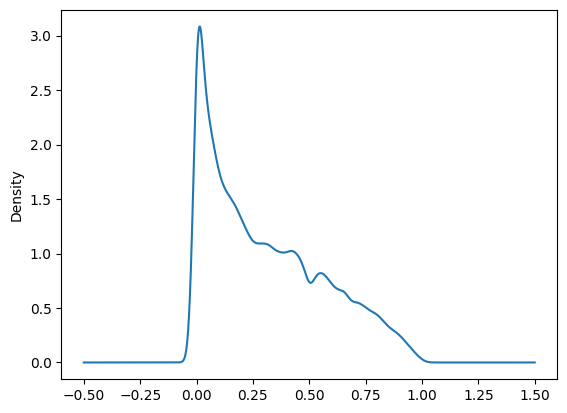

In [94]:
timeperc_within_stay.plot.kde()

In [98]:
hospicdproc_r2_df = hospicdproc_r2_df.merge(adm_df, on='hadm_id', how='left' )
hospicdproc_r2_df

,hadm_id,days_from_admission,days_to_discharge,chartdate,icd_code,icd_version,long_title,subject_id,admittime,dischtime
0,28979390,0.562500,1.625000,2189-10-16,5551,9,Nephroureterectomy,10000560,2189-10-15 10:30:00,2189-10-17 15:00:00
1,21544441,0.000000,11.673611,2131-06-04,0TTB4ZZ,10,"Resection of Bladder, Percutaneous Endoscopic ...",10001401,2131-06-04 00:00:00,2131-06-15 16:10:00
2,21544441,0.000000,11.673611,2131-06-04,07BC4ZX,10,"Excision of Pelvis Lymphatic, Percutaneous End...",10001401,2131-06-04 00:00:00,2131-06-15 16:10:00
3,21544441,0.000000,11.673611,2131-06-04,0UT9FZZ,10,"Resection of Uterus, Via Natural or Artificial...",10001401,2131-06-04 00:00:00,2131-06-15 16:10:00
4,21544441,0.000000,11.673611,2131-06-04,0UTC7ZZ,10,"Resection of Cervix, Via Natural or Artificial...",10001401,2131-06-04 00:00:00,2131-06-15 16:10:00
...,...,...,...,...,...,...,...,...,...,...
384074,23033573,0.226389,2.680556,2171-08-02,0DBN8ZX,10,"Excision of Sigmoid Colon, Via Natural or Arti...",19999464,2171-08-01 18:34:00,2171-08-04 16:20:00
384075,23033573,0.226389,2.680556,2171-08-02,0DBP8ZX,10,"Excision of Rectum, Via Natural or Artificial ...",19999464,2171-08-01 18:34:00,2171-08-04 16:20:00
384076,25304202,3.245833,2.145833,2139-10-14,966,9,Enteral infusion of concentrated nutritional s...,19999625,2139-10-10 18:06:00,2139-10-16 03:30:00
384077,23664472,11.834028,4.747222,2119-08-05,00UT0JZ,10,Supplement Spinal Meninges with Synthetic Subs...,19999784,2119-07-24 03:59:00,2119-08-09 17:56:00


In [104]:
icd_n_subjects = hospicdproc_r2_df.groupby(['icd_code'], as_index=False).agg(n_subjects=('subject_id', 'nunique'))

<AxesSubplot:>

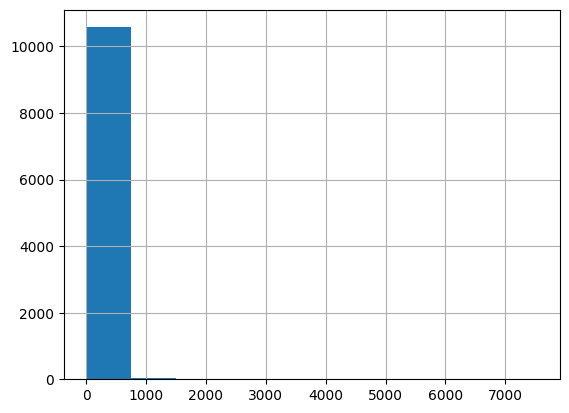

In [106]:
icd_n_subjects.n_subjects.hist()

In [41]:
hospicdproc_df.groupby(['hadm_id', 'icd_code']).size().reset_index()

,hadm_id,icd_code,0
0,20000041,8154,1
1,20000069,0KQM0ZZ,1
2,20000069,10E0XZZ,1
3,20000102,7309,1
4,20000102,7359,1
...,...,...,...
636377,29999670,0046,1
636378,29999670,0066,1
636379,29999670,3606,1
636380,29999670,8856,1


In [15]:
poe_df

,hadm_id,offset,poe_id,order_type,order_subtype,transaction_type,field_name,field_value
0,28919637,2.136204,10029057-106,IV therapy,IV fluids,New,None,None
1,28919637,0.540556,10029057-57,Medications,None,New,None,None
2,24064303,1.690799,10029074-63,Medications,None,New,None,None
3,20347783,0.975567,10029206-49,Medications,None,New,None,None
4,20347783,2.650567,10029206-67,Medications,None,New,None,None
...,...,...,...,...,...,...,...,...
40523848,22343816,0.104792,10028480-450,Nutrition,Diet Order,New,None,None
40523849,24169188,3.068090,10028480-804,Lab,None,New,None,None
40523850,24169188,4.983426,10028480-817,Medications,None,Change,None,None
40523851,27911538,-0.235556,10028480-912,Lab,None,New,None,None


In [38]:
poe_df[poe_df.order_subtype == 'Thoracic Surgery'].field_value.unique()

array(['Routine (within 24 hours)', 'Urgent (within 2 hours)', None,
       '2143-04-10 11:29:13', 'Accepted', '2144-12-24 11:33:20',
       'Immediate', '2143-08-04 22:19:25', '2121-04-23 18:26:33',
       '2174-07-11 16:50:09', '2117-06-11 11:48:26',
       '2130-09-14 21:15:37', '2143-08-04 22:19:09',
       '2175-05-22 16:44:21', '2134-06-25 22:39:25',
       '2117-01-02 22:40:58', '2157-02-17 09:55:15',
       '2180-07-09 17:27:47', '2138-08-18 16:47:18',
       '2119-04-01 17:28:13', '2151-05-05 08:27:03',
       '2155-03-24 20:45:01', '2134-05-26 16:49:25',
       'Placed Under Review', '2160-07-11 07:18:55',
       '2181-10-27 22:20:06', '2160-07-04 06:01:27',
       '2136-02-16 09:33:08', '2153-06-20 11:28:07',
       '2193-10-12 16:43:14', '2110-09-06 22:40:30',
       '2166-02-28 15:55:22', '2161-05-05 00:26:33'], dtype=object)

In [20]:
poe_df.order_subtype.unique()

array(['IV fluids', None, 'Activity', 'Vitals/Monitoring', 'Admit',
       'Other', 'ECG', 'Telemetry', 'Code status', 'MRI',
       'Red Cell Product Order', 'Discharge', 'Oxygen Therapy',
       'Speech/Swallowing', 'IV access', 'General Xray', 'Tubes/Drains',
       'Blood tests', 'CT Scan', 'Mechanical Ventilation', 'Diet Order',
       'IV access request', 'Noninvasive Vascular',
       'Hemodynamic monitoring', 'NPO/Diet for Procedure', 'Postop',
       'Therapeutic devices/DVT/Prophylaxis',
       'Discharge Followup Appointment', 'Frozen Plasma Product Order',
       'Wound Care', 'Spiritual Care/Chaplaincy',
       'Premixed Central Standard', 'Precautions', 'CPAP for OSA',
       'Ultrasound', 'Platelet Product Order', 'Occupational Therapy',
       'Tubefeeding Order', 'Nutrition consult', 'Physical Therapy',
       'Echo', 'PO fluid restriction', 'Restraints', 'Hemodialysis',
       'Stress Echo', 'Transfer', 'Extubate', 'Hematology-Oncology',
       'Palliative Care', 'Soc

In [151]:
## NUMERIC FEATURES
## TODO: add mergers across tables and within-tables.

blood_gas = ['so2', 'po2', 'pco2', 'fio2', 'fio2_chartevents', 'aado2', 'aado2_calc', 'pao2fio2ratio', 'ph', 'baseexcess', 'bicarbonate', 'totalco2', 'hematocrit', 'hemoglobin', 'carboxyhemoglobin', 'methemoglobin', 'chloride', 'calcium', 'temperature', 'potassium', 'sodium', 'lactate', 'glucose']

blood_chemistry = ['albumin','globulin','total_protein','aniongap','bicarbonate','bun','calcium','chloride','creatinine','glucose','sodium','potassium']

cardiac_markers = ['troponin_t','ntprobnp','ck_mb']

cbc = ['hematocrit','hemoglobin','mch','mchc','mcv','platelet','rbc','rdw','rdwsd','wbc']

vital_signs = ['heart_rate','sbp','dbp','mbp','sbp_ni','dbp_ni','mbp_ni','resp_rate','temperature','spo2','glucose']

# Glasgow Coma Scale, a measure of neurological function
coma_signs = ['gcs','gcs_motor','gcs_verbal','gcs_eyes','gcs_unable']

renal_out = ['uo_rt_6hr', 'uo_rt_12hr', 'uo_rt_24hr']

renal_creat = ['creat']

renal_aki = ['aki_stage_smoothed']

In [152]:
def filter_measurements(df):
    n0 = len(df)
    
    cols = df.columns
    
    # Filter measurements correspond to less than 12 hours admission.
    df = df[df.hadm_id.isin(hadm_id_los_geq_12h)]
    
    n1 = len(df)
    
    # Merge with admissions to filter measurements with time_bin outside the hosp stay.
    df_ = df.merge(adm_df, on='hadm_id', how='left')
    mask = df_.time_bin.between(df_.admittime, df_.dischtime)
    
    df_ = df_[mask]
    df = df_[cols]
    n2 = len(df)
    
    print(' => '.join(f'{n} ({100 * n / n0:.1f})' for n in (n0, n1, n2)))
    return df

### Numeric Feature Tables

In [153]:
agg_interval = 'hour'
# For higher resolution binning see: 
# https://stackoverflow.com/questions/7299342/what-is-the-fastest-way-to-truncate-timestamps-to-5-minutes-in-postgres

# Time-binning can be specific for each table

In [154]:
blood_gas_query = f"""
select hadm_id,
       {', '.join(map(lambda e: f'avg(bg.{e}) as {e}', blood_gas))},
       date_trunc('{agg_interval}', bg.charttime) time_bin
from mimiciv_derived.bg as bg
group by hadm_id, time_bin
"""

bg_df = pd.read_sql_query(blood_gas_query,con)

In [155]:
bg_df = filter_measurements(bg_df)

491564 (100.0) => 442007 (89.9) => 435518 (88.6)


In [156]:
blood_chemistry_query = f"""
select hadm_id,
       {', '.join(map(lambda e: f'avg(ch.{e}) as {e}', blood_chemistry))},
       date_trunc('{agg_interval}', ch.charttime) time_bin
from mimiciv_derived.chemistry as ch
group by hadm_id, time_bin
"""

ch_df = pd.read_sql_query(blood_chemistry_query,con)

In [157]:
ch_df = filter_measurements(ch_df)

2530982 (100.0) => 1987259 (78.5) => 1938598 (76.6)


In [158]:
cardiac_marker_query = \
f"""
WITH trop AS
(
    SELECT specimen_id, MAX(valuenum) AS troponin_t
    FROM mimiciv_hosp.labevents
    WHERE itemid = 51003
    GROUP BY specimen_id
)
SELECT
    c.hadm_id
    , date_trunc('{agg_interval}', c.charttime) time_bin
    , avg(trop.troponin_t) as troponin_t
    , avg(c.ntprobnp) as ntprobnp
    , avg(c.ck_mb) as ck_mb
FROM mimiciv_hosp.admissions a
LEFT JOIN mimiciv_derived.cardiac_marker c
  ON a.hadm_id = c.hadm_id
LEFT JOIN trop
  ON c.specimen_id = trop.specimen_id
GROUP BY c.hadm_id, time_bin
"""

cardiac_df = pd.read_sql_query(cardiac_marker_query,con)

In [159]:
cardiac_df = filter_measurements(cardiac_df)

179011 (100.0) => 177838 (99.3) => 167968 (93.8)


In [160]:
temp_query = \
f"""
WITH temp_t AS (
    SELECT c.hadm_id
        , c.charttime
        , CASE
            WHEN LOWER(c.valueuom)  like '%°f%' THEN (c.valuenum - 32) / 1.8
                ELSE c.valuenum
          END AS temperature
    FROM mimiciv_hosp.admissions a
    INNER JOIN mimiciv_icu.chartevents c
      ON a.hadm_id = c.hadm_id
    INNER JOIN mimiciv_icu.d_items di
      ON c.itemid = di.itemid
    AND c.itemid IN
    (
    227632, -- Arctic Sun/Alsius Temp #1 C
    227634, -- Arctic Sun/Alsius Temp #2 C
    223761 -- Temperature Fahrenheit
    )
    AND valuenum > 10 AND valuenum < 120
)
SELECT temp_t.hadm_id
     , AVG(temp_t.temperature) temperature
     , DATE_TRUNC('{agg_interval}', temp_t.charttime) time_bin
FROM temp_t
GROUP BY temp_t.hadm_id, time_bin
"""
temp_df = pd.read_sql_query(temp_query,con)

In [161]:
temp_df = filter_measurements(temp_df)

1534954 (100.0) => 1533292 (99.9) => 1526910 (99.5)


In [162]:
cbc_query = f"""
select hadm_id,
       {', '.join(map(lambda e: f'avg(cbc.{e}) as {e}', cbc))},
       date_trunc('{agg_interval}', cbc.charttime) time_bin
from mimiciv_derived.complete_blood_count as cbc
group by hadm_id, time_bin
"""
cbc_df = pd.read_sql_query(cbc_query, con)

In [163]:
cbc_df = filter_measurements(cbc_df)

2463587 (100.0) => 1925075 (78.1) => 1874499 (76.1)


In [164]:
vital_query = f"""
select icu.hadm_id,
       {', '.join(map(lambda e: f'avg(v.{e}) as {e}', vital_signs))},
       date_trunc('{agg_interval}', v.charttime) time_bin
from mimiciv_derived.vitalsign as v
inner join mimiciv_icu.icustays as icu
 on icu.stay_id = v.stay_id
group by icu.hadm_id, time_bin
"""
vital_df = pd.read_sql_query(vital_query, con)

In [165]:
vital_df = filter_measurements(vital_df)

5886450 (100.0) => 5880273 (99.9) => 5861008 (99.6)


In [166]:
gcs_query = f"""
select icu.hadm_id,
       {', '.join(map(lambda e: f'avg(gcs.{e}) as {e}', coma_signs))},
       date_trunc('{agg_interval}', gcs.charttime) time_bin
from mimiciv_derived.gcs as gcs
inner join mimiciv_icu.icustays as icu
 on icu.stay_id = gcs.stay_id
group by icu.hadm_id, time_bin
"""
gcs_df = pd.read_sql_query(gcs_query, con)

In [167]:
gcs_df = filter_measurements(gcs_df)

1628182 (100.0) => 1626537 (99.9) => 1621695 (99.6)


In [168]:
renal_out_query = f"""
select icu.hadm_id,
       {', '.join(map(lambda e: f'avg(r.{e}) as {e}', renal_out))},
       date_trunc('{agg_interval}', r.charttime) time_bin
from mimiciv_derived.kdigo_uo as r
inner join mimiciv_icu.icustays as icu
 on icu.stay_id = r.stay_id
group by icu.hadm_id, time_bin
"""

renal_creat_query = f"""
select icu.hadm_id,
       {', '.join(map(lambda e: f'avg(r.{e}) as {e}', renal_creat))},
       date_trunc('{agg_interval}', r.charttime) time_bin
from mimiciv_derived.kdigo_creatinine as r
inner join mimiciv_icu.icustays as icu
 on icu.stay_id = r.stay_id
group by icu.hadm_id, time_bin
"""

renal_aki_query = f"""
select icu.hadm_id,
       {', '.join(map(lambda e: f'avg(r.{e}) as {e}', renal_aki))},
       date_trunc('{agg_interval}', r.charttime) time_bin
from mimiciv_derived.kdigo_stages as r
inner join mimiciv_icu.icustays as icu
 on icu.stay_id = r.stay_id
group by icu.hadm_id, time_bin
"""

renal_out_df = pd.read_sql_query(renal_out_query, con)
renal_creat_df = pd.read_sql_query(renal_creat_query, con)
renal_aki_df = pd.read_sql_query(renal_aki_query, con)


In [169]:
renal_out_df = filter_measurements(renal_out_df)
renal_creat_df = filter_measurements(renal_creat_df)
renal_aki_df = filter_measurements(renal_aki_df)

3294878 (100.0) => 3292534 (99.9) => 3285718 (99.7)
568158 (100.0) => 566564 (99.7) => 502249 (88.4)
3687859 (100.0) => 3684212 (99.9) => 3613898 (98.0)


In [ ]:

bg_df.to_csv('bg.csv.gz', compression='gzip')
ch_df.to_csv('ch.csv.gz', compression='gzip')
cardiac_df.to_csv('cardiac.csv.gz', compression='gzip')
temp_df.to_csv('temp.csv.gz', compression='gzip')
cbc_df.to_csv('cbc.csv.gz', compression='gzip')
vital_df.to_csv('vital.csv.gz', compression='gzip')
gcs_df.to_csv('gcs.csv.gz', compression='gzip')

In [ ]:
renal_out_df.to_csv('renal_out.csv.gz', compression='gzip')
renal_creat_df.to_csv('renal_creat.csv.gz', compression='gzip')
renal_aki_df.to_csv('renal_aki.csv.gz', compression='gzip')
